In [6]:
import numpy as np
import math
import scipy as sp
from scipy import optimize
from numpy import genfromtxt
import pandas as pd 
import glob
import pymc as pm
import arviz as az
import statistics as stats
import matplotlib.pyplot as plt
import os,sys

In [7]:
# getting the name of the directory
# where the this file is present.
# current = os.path.dirname(os.path.realpath(__file__))
current = os.path.dirname(os.getcwd())
 
# Getting the parent directory name
# where the current directory is present.
# parent = os.path.dirname(os.path.dirname(current))
parent = current
print(parent)
#/Users/pizarror/IDM

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

from IDM_model.src import model_functions as mf

/Users/pizarror/IDM


In [8]:
def read_load_data(subject='23_IDM_0144',fn='/tmp',alpha0=1.0,cols=[]):
    df = pd.read_csv(fn)
    # remove practice trials
    df = df.loc[df['cdd_trial_type']=='task']
    data = mf.get_data(df,cols,alpha_hat=alpha0)[0]
    data['subject'] = subject
    return data

def diganostic_plots(trace,nb_subjects=1,var_names=['kappa','gamma'],figsize=(10,10)):
    az.plot_trace(trace, var_names=var_names,compact=False)
    plt.tight_layout()
    az.plot_pair(trace,kind='kde', var_names=var_names,marginals=True)
    az.plot_posterior(trace,var_names=var_names)

    fig, axes = plt.subplots(nb_subjects,len(var_names), figsize=figsize)
    az.plot_rank(trace,var_names=var_names,ax=axes)
    fig.tight_layout()

    fig, axes = plt.subplots(nb_subjects,len(var_names), figsize=figsize)
    axes = az.plot_rank(trace,var_names=var_names, kind="vlines",vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3},ax=axes)
    # plt.ylim([-0.001,0.001])
    plt.tight_layout()


## Complete Pooling

Complete pooling ignores the group-level information and considers all data as belonging to the same category. All groups are described with the same model. 

We are using complete pooling to generate priors for when we implement a higherarchical bayesian model.

### Load data

We will load the data from all participants so we can run the modeling schema

In [9]:

# Takes about 16 seconds

# we will change this when we change utility to 1st level analysis (or split)
split_dir = '/Volumes/UCDN/datasets/IDM/split/'
save_dir = '/Volumes/UCDN/datasets/IDM/BH/csv'
subjs = sorted(glob.glob(os.path.join(split_dir,'23_IDM_*')))
task = 'cdd'
# cols = ['cdd_trial_resp.corr','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
cols = ['cdd_choice','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
data = pd.DataFrame(columns=['subject']+cols)

for s in subjs:
    subject = os.path.basename(s)
    fn  = os.path.join(s,task,'{}_{}.csv'.format(os.path.basename(s),task))
    if os.path.exists(fn):
        subj_data = read_load_data(subject=subject,fn=fn,alpha0=1.0,cols=cols)
        data = pd.concat([data,subj_data],ignore_index=True)
    else:
        print('Could not find : {}'.format(fn))

data





,subject,cdd_choice,cdd_immed_amt,cdd_delay_amt,cdd_immed_wait,cdd_delay_wait,alpha
0,23_IDM_0001,1.0,5.0,26.0,0.0,29.0,1.0
1,23_IDM_0001,1.0,2.0,22.0,0.0,90.0,1.0
2,23_IDM_0001,0.0,2.0,6.0,0.0,90.0,1.0
3,23_IDM_0001,0.0,15.0,15.0,0.0,151.0,1.0
4,23_IDM_0001,1.0,15.0,55.0,0.0,90.0,1.0
...,...,...,...,...,...,...,...
14222,23_IDM_0149,1.0,2.0,12.0,0.0,11.0,1.0
14223,23_IDM_0149,0.0,20.0,24.0,0.0,150.0,1.0
14224,23_IDM_0149,0.0,2.0,41.0,0.0,149.0,1.0
14225,23_IDM_0149,1.0,10.0,65.0,0.0,4.0,1.0


### Estimate pooled model

Now we can run this completely model to get a prior for when we run the next round of BH model

In [22]:
# This is a pool model. This is not good for our case. It will just get one k and one b for each session, but it won't incorporate everyone's data. Returns wonky values as far as I remember.

# takes approximately 10 minutes

with pm.Model() as model_pool:

    kappa = pm.Beta('kappa',mu=0.3,sigma=0.2,shape=1)#np.size(SSA)) #mu=0.1, mu=0.07,sd=0.1 05
    gamma = pm.HalfNormal('gamma',sigma=0.5,shape=1)#np.size(SSA)) #mu=0.1, mu=0.005,sd=0.01 mu=0,
    
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma * ( data['cdd_delay_amt'].values/(1+(kappa*data['cdd_delay_wait'].values)) - 
                                                                   data['cdd_immed_amt'].values/(1+(kappa*data['cdd_immed_wait'].values)) ))))

    y_1 = pm.Bernoulli('y_1',p=prob,observed=data['cdd_choice'])

    trace_pool = pm.sample(1000, tune=100, cores=2,target_accept=0.99)

# This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
Summary= az.summary(trace_pool,var_names=['kappa','gamma'],round_to=10)
# Again, call it what you want (yeah - call it what you want tooooo)
fn = os.path.join(save_dir,"completely_pooled_model_2chains.csv")
Summary.to_csv(fn)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [kappa, gamma]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [23]:
Summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kappa[0],0.020268,0.000500,0.019384,0.021230,0.000019,0.000013,712.917830,700.490086,1.001899
gamma[0],0.130130,0.002702,0.125275,0.135301,0.000087,0.000062,956.209236,840.584519,1.001536


In [11]:
fn = os.path.join(save_dir,'completely_pooled_model.csv')
pool_model = pd.read_csv(fn,index_col=0)

mu_kappa,std_kappa = pool_model.loc['kappa[0]','mean'],pool_model.loc['kappa[0]','sd']
mu_gamma,std_gamma = pool_model.loc['gamma[0]','mean'],pool_model.loc['gamma[0]','sd']

print('For kappa, use the following (mu,sigma) : ({},{})'.format(mu_kappa, std_kappa))
print('For gamma, use the following (mu,sigma) : ({},{})'.format(mu_gamma, std_gamma))

For kappa, use the following (mu,sigma) : (0.0202632834,0.0005014986)
For gamma, use the following (mu,sigma) : (0.1300484166,0.0027491151)


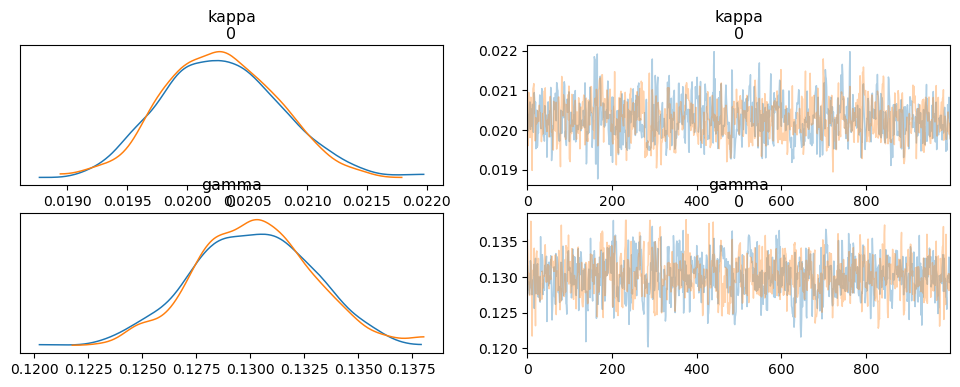

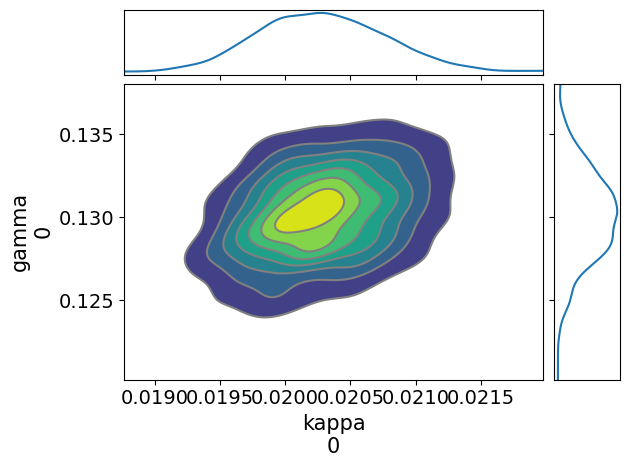

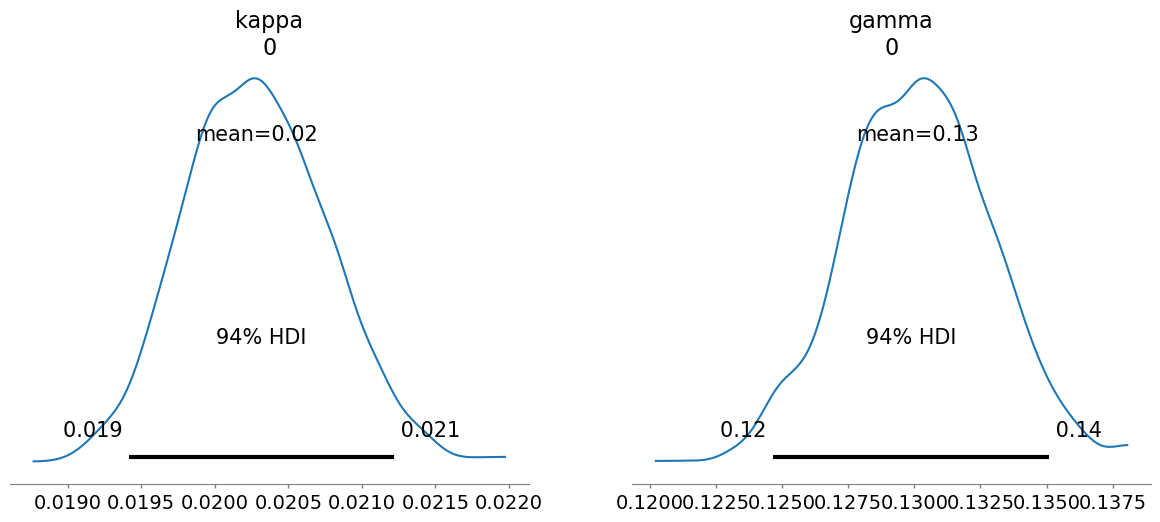

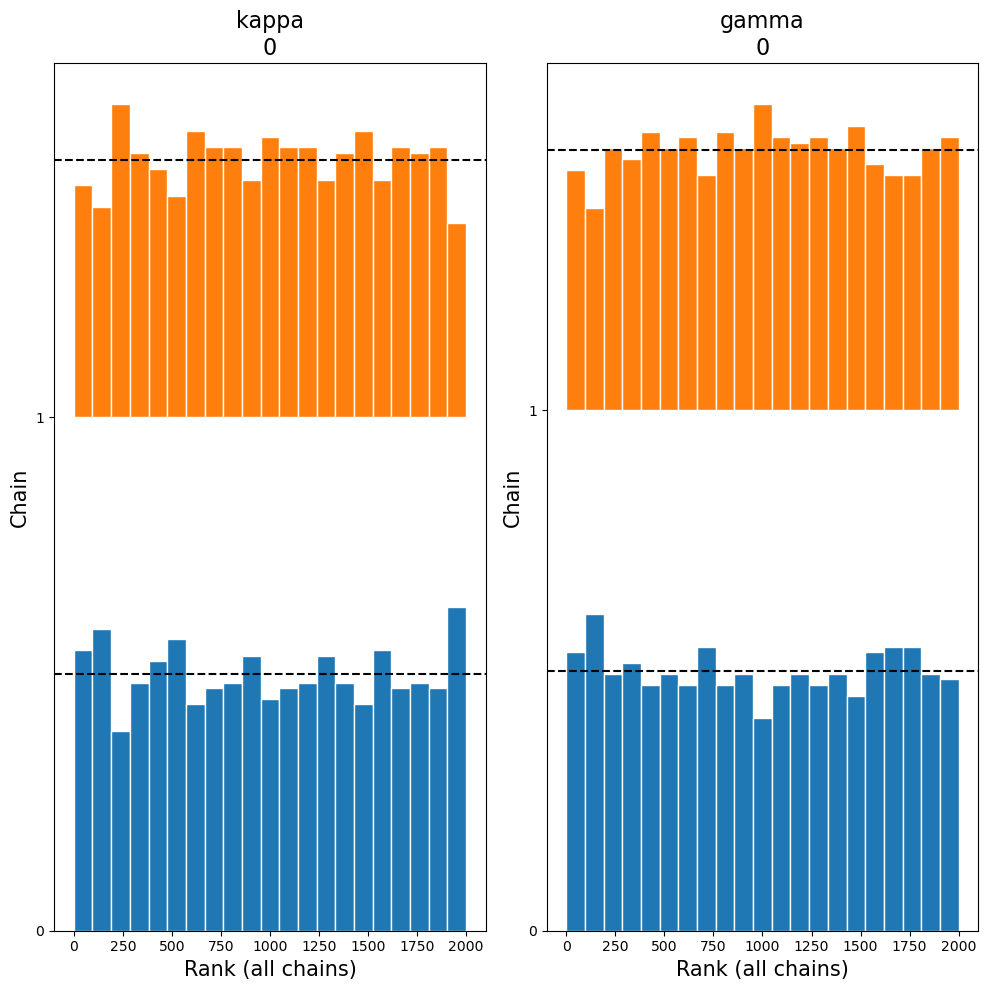

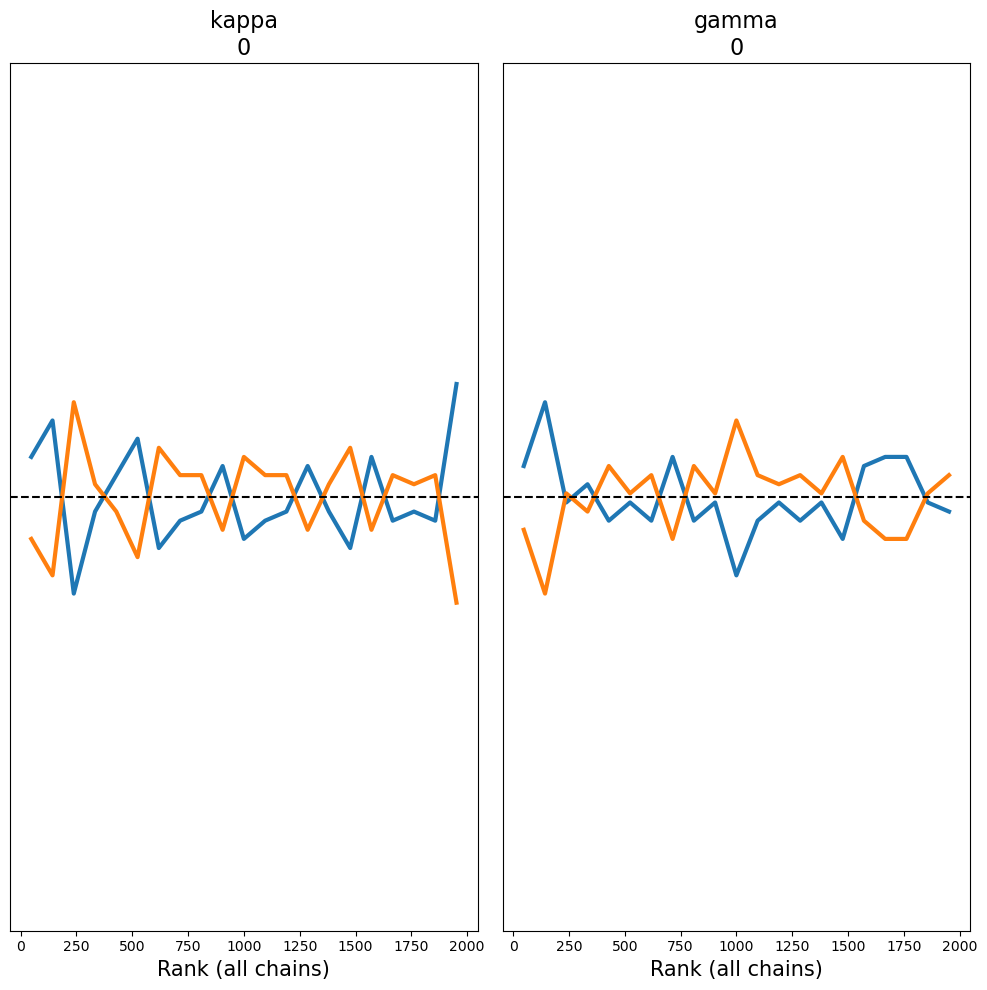

In [19]:
diganostic_plots(trace_pool,nb_subjects=1,var_names=['kappa','gamma'],figsize=(10,10))